In [1]:
cd /content/drive/MyDrive/Experiment2YOLOV5/FINAL2

[Errno 2] No such file or directory: '/content/drive/MyDrive/Experiment2YOLOV5/FINAL2'
/content


In [ ]:
!pip install patool


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.8 MB/s 


In [ ]:
import patoolib
from rarfile import RarFile
patoolib.extract_archive("/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images.rar", outdir="/content/drive/MyDrive/Experiment2YOLOV5/FINAL2")

patool: Extracting /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images.rar
patool:     with cwd='/content/drive/MyDrive/Experiment2YOLOV5/FINAL2'
patool: ... /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images.rar extracted to `/content/drive/MyDrive/Experiment2YOLOV5/FINAL2'.


'/content/drive/MyDrive/Experiment2YOLOV5/FINAL2'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import random
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
print(extract_info_from_xml('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/annotations/xmls/China_MotorBike_000000.xml'))

{'bboxes': [{'class': 'Repair', 'xmin': 141, 'ymin': 64, 'xmax': 512, 'ymax': 512}, {'class': 'D20', 'xmin': 169, 'ymin': 1, 'xmax': 512, 'ymax': 180}, {'class': 'D20', 'xmin': 419, 'ymin': 180, 'xmax': 512, 'ymax': 295}, {'class': 'D00', 'xmin': 124, 'ymin': 1, 'xmax': 148, 'ymax': 45}], 'filename': 'China_MotorBike_000000.jpg', 'image_size': (512, 512, 3)}


In [ ]:
class_name_to_id_mapping = {"D00": 0,
                           "D10": 1,
                           "D20": 2,
                           "Repair": 3,
                            "D40":4,
                            'collapse':5}

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/lables1

/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/lables1


In [ ]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    #save_file_name = os.path.join("final", info_dict["filename"].replace("txt", "xml"))
    
    save_file_name = info_dict["filename"].replace("jpg", "txt")
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/annotations/xmls', x) for x in os.listdir('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/annotations/xmls') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/annotations/xmls', x) for x in os.listdir('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/annotations/xmls') if x[-3:] == "txt"]

100%|██████████| 2679/2679 [01:11<00:00, 37.53it/s] 


In [ ]:

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()



In [ ]:
annotations = [os.path.join('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/lables1', x) for x in os.listdir('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/lables1') if x[-3:] == "txt"]

[['0', '0.385', '0.284', '0.121', '0.443'], ['0', '0.170', '0.732', '0.242', '0.465'], ['1', '0.246', '0.416', '0.270', '0.035'], ['1', '0.642', '0.504', '0.416', '0.066'], ['1', '0.586', '0.328', '0.270', '0.023'], ['1', '0.570', '0.212', '0.137', '0.045']]


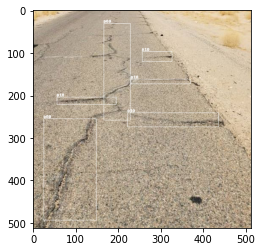

In [ ]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
#annotation_file=annotations1[-1]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("lables", "images").replace("txt", "jpg")

assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
images = [os.path.join('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images1', x) for x in os.listdir('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images1')]
annotations = [os.path.join('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/lables1', x) for x in os.listdir('/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/lables1') if x[-3:] == "txt"]

In [ ]:
len(images)

2679

In [ ]:
images.sort()
annotations.sort()

In [ ]:
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)

In [ ]:
cd /content/drive/MyDrive/Experiment2YOLOV5/FINAL2

/content/drive/.shortcut-targets-by-id/1sPdyF6vo4tq9Y3cq4kmFGUYQlsBqexyc/Experiment2YOLOV5/FINAL2


In [ ]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
#move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
#move_files_to_folder(test_annotations, 'annotations/test/')

In [7]:
cd /content/drive/MyDrive/Experiment2YOLOV5/FINAL2

/content/drive/MyDrive/Experiment2YOLOV5/FINAL2


In [6]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14862, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14862 (delta 0), reused 0 (delta 0), pack-reused 14858
Receiving objects: 100% (14862/14862), 13.87 MiB | 5.68 MiB/s, done.
Resolving deltas: 100% (10229/10229), done.


In [8]:
cd /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/yolov5

/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/yolov5


In [9]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 5.3 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 1.6 MB 61.6 MB/s 


In [11]:
!python train.py --img 400 --cfg /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/yolov5s.yaml --hyp /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/hyp.scratch.yaml --batch 32 --epochs 100 --data /content/drive/MyDrive/Experiment2YOLOV5/FINAL2/china.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det_2

train: weights=yolov5s.pt, cfg=/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/yolov5s.yaml, data=/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/china.yaml, hyp=/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=400, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_road_det_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-46-g96a71b1 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=

In [19]:
import torch
model = torch.hub.load( 'ultralytics/yolov5', 'custom', '/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/yolov5/runs/train/yolo_road_det_23/weights/best.pt')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-23 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 166 layers, 7067395 parameters, 0 gradients
Adding AutoShape... 


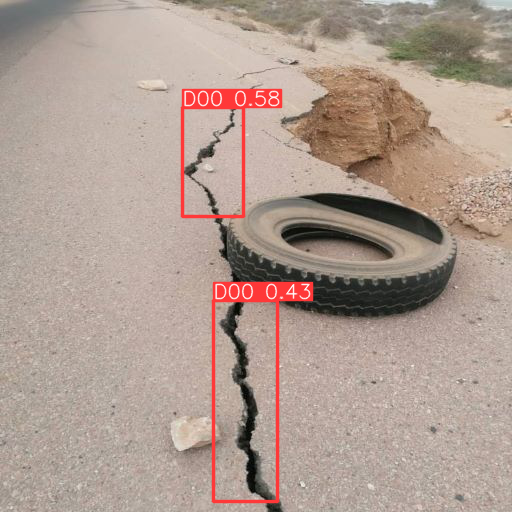

In [28]:
im = '/content/drive/MyDrive/Experiment2YOLOV5/FINAL2/images1/595.jpg'  # or file, Path, URL, PIL, OpenCV, numpy, list

# Inference
results = model(im)
results.show()